In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import mpl_toolkits.mplot3d

from scipy.optimize import fsolve

import numpy as np


import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [96]:
def torus_phyllotaxis_points(N):
    R, r = 1, 1/3
    gr = (1 + np.sqrt(5))/2
    gamma = 2*np.pi*(1- 1/gr)
    pmax = 2*np.pi
    caparea = lambda x: 2*np.pi*(3*x + np.sin(x))/9
    c = N/caparea(pmax)
    t = np.arange(1,N+1)*gamma
    p = np.zeros(N)
    p[0] = fsolve(lambda x: caparea(x)-1/c, 0)
    for i in range(1,N):
        p[i] = fsolve(lambda x: caparea(x)-i/c, p[i-1])
    nodes = np.zeros((N, 3))
    nodes[:, 0] = (R + r*np.cos(p)) * np.cos(t)
    nodes[:, 1] = (R + r*np.cos(p)) * np.sin(t)
    nodes[:, 2] = r*np.sin(p)

    normals = np.zeros((N,3))
    normals[:, 0] = r*np.cos(p)*np.cos(t)*(R+r*np.cos(p))
    normals[:, 1] = r*np.cos(p)*np.sin(t)*(R+r*np.cos(p))
    normals[:, 2] = r*np.sin(p) * (R + r*np.cos(p)) * np.cos(t)**2 + r*np.sin(p) * (R+r*np.cos(p))*np.sin(t)**2
    
    return nodes, normals

In [97]:
nodes, normals = torus_phyllotaxis_points(50)

<IPython.core.display.Javascript object>


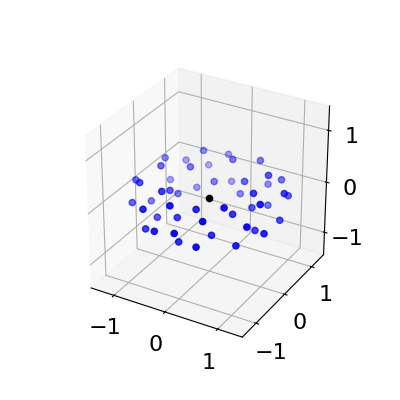

In [98]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nodes[:,0], nodes[:,1], nodes[:,2], '.', color='b')
ax.scatter(0, 0, 0, '.', color='k')

ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-1.4,1.4)
plt.show()

In [17]:
def get_parameters(x, R, r):
    theta = np.arctan2(x[:,1], x[:,0])
    phi = np.arctan2(x[:,2], np.sqrt(x[:,0]**2 + x[:,1]**2) - R)
    return theta, phi

def torus_to_cart(theta, phi, R, r):
    nodes = np.zeros((len(phi), 3))
    nodes[:,0] = (R + r*np.cos(phi))*np.cos(theta)
    nodes[:,1] = (R + r*np.cos(phi))*np.sin(theta)
    nodes[:,2] = r*np.sin(phi)
    return nodes

In [99]:
# theta, phi = get_parameters(nodes, 1, 1/3)
theta_cs = [0, .5,   1,    2, 4, 5, 3.141]
phi_cs   = [0,  4, 1.5, -1.5, 0, 4, 3.141/2]
# phi_cs = [0]*len(theta_cs)
centers = torus_to_cart(np.array(theta_cs), np.array(phi_cs), 1, 1/3)

<IPython.core.display.Javascript object>


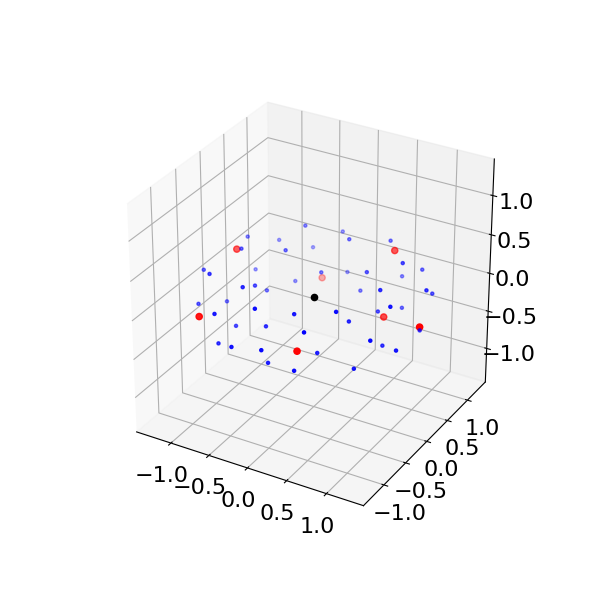

In [100]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nodes[:,0], nodes[:,1], nodes[:,2], '.', color='b', marker='.')
ax.scatter(centers[:,0], centers[:,1], centers[:,2], '.', color='r', marker='o')
ax.scatter(0, 0, 0, '.', color='k')

ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-1.4,1.4)
plt.show()

In [147]:
def torus_forcing(nodes):
    # I don't know what these are... maybe related to curvature?
    a, b = 9, 3
    s = 0
    
    # create gaussian centers
    theta_cs = np.array([0, .5,   1,    2, 4, 5, 3.141])
    phi_cs   = np.array([0,  4, 1.5, -1.5, 0, 4, 3.141/2])
    centers = torus_to_cart(theta_cs, phi_cs, 1, 1/3)
    
    thetas, phis = get_parameters(nodes, 1, 1/3)
    
    N = len(nodes)
    K = len(centers)
    
    us = np.zeros(N)
    fs = np.zeros(N)
    
    cth, sth = np.cos(thetas), np.sin(thetas)
    for k in range(K):
        slak = np.sin(phis - phi_cs[k])
        clak = np.cos(phis - phi_cs[k])
        sthk = np.sin(thetas - theta_cs[k])
        cthk = np.cos(thetas - theta_cs[k])
        
        uk = np.exp(-a**2*(1-clak) - b**2*(1-cthk))
        C = a**4*slak**2-9*b**2*cthk-a**2*clak+9*b**4*sthk**2-6*b**2*cthk*cth+ \
               3*b**2*sthk*sth-b**2*cthk*cth**2+6*b**4*sthk**2*cth+b**4*sthk**2*cth**2+ \
               b**2*sthk*cth*sth
        fs += (-s - 9*C/(cth+3)**2)*uk
        us += uk
    return us, fs

<IPython.core.display.Javascript object>


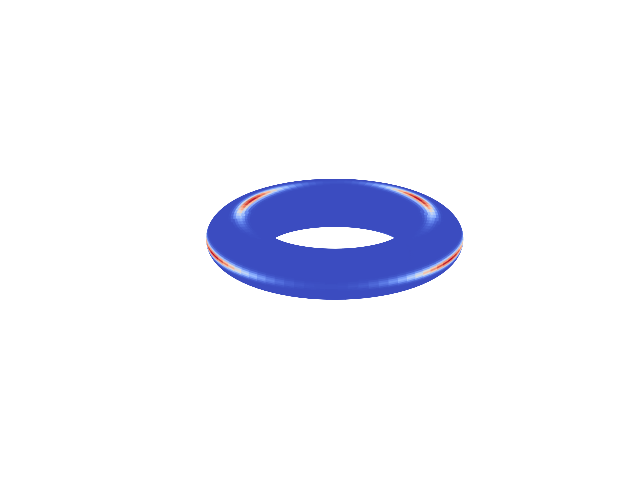

In [148]:
n = 80

thetas = np.linspace(0, 2*np.pi, n)
phis = np.linspace(0, 2*np.pi, n)

U = np.outer(np.ones(n), thetas).flatten()
V = np.outer(phis, np.ones(n)).flatten()

nodes = torus_to_cart(U, V, 1, 1/3)

X = nodes[:, 0].reshape((n,n))
Y = nodes[:, 1].reshape((n,n))
Z = nodes[:, 2].reshape((n,n))

us, fs = torus_forcing(nodes)

val = us.reshape((n,n))

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure()
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-1.4,1.4)

plt.axis('off')
ax.grid(False)

<IPython.core.display.Javascript object>


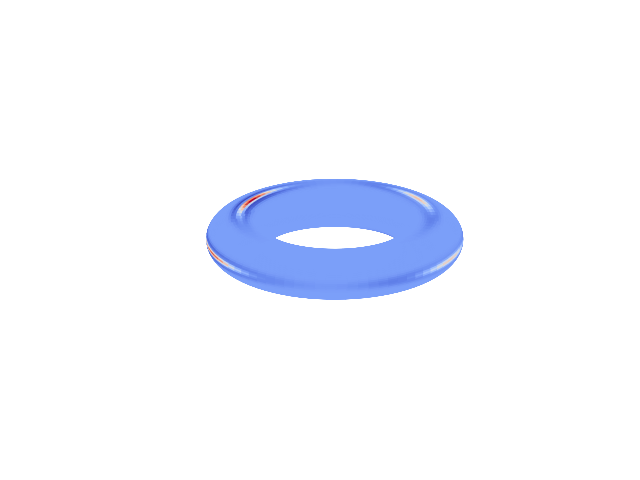

In [149]:
val = fs.reshape((n,n))
# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure()
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-1.4,1.4)

plt.axis('off')
ax.grid(False)

# Diffusion testing

In [117]:
from laplacebeltrami import *
from rbf import *

In [139]:
nodes, normals = torus_phyllotaxis_points(20000)
us, fs = torus_forcing(nodes)

In [129]:
C = TPM(nodes, normals, rbf_obj=rbf_dict['r^10 log(r)'], epsilon=None, stencil_size=100, poly_deg=4)

In [ ]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^10 log(r)'], epsilon=None, stencil_size=100, poly_deg=4)

In [ ]:
C = SOGr(nodes, normals, rbf_obj=rbf_dict['r^10 log(r)'], stencil_size=100, poly_deg=4)

In [140]:
print(C @ us - fs)
print(C @ us + fs)
print(C @ fs - us)
print(C @ fs + us)

[ 9.25388103e+00 -1.58158395e+01  4.96644991e+02 ...  6.74577767e-03
  5.06304593e+01 -5.53445777e+01]
[  9.24725402 -15.81607474 496.74256126 ...  -1.0896395   12.70185619
 -55.06171019]
[ -39977.38259773 -710700.92932761  510312.7143527  ...   -9964.75389501
   14922.38617284  105680.2424817 ]
[ -39977.38259695 -710700.92932748  510312.71470649 ...   -9964.7538112
   14922.39103808  105680.24294647]


In [141]:
fs

array([-3.31350371e-03, -1.17604609e-04,  4.87850907e-02, ...,
       -5.48192640e-01, -1.89643015e+01,  1.41433772e-01])

In [142]:
us

array([3.89508569e-07, 6.82647050e-08, 1.76892936e-04, ...,
       4.19061862e-05, 2.43261690e-03, 2.32385247e-04])

In [143]:
C @ us

array([  9.25056753, -15.81595714, 496.69377617, ...,  -0.54144686,
        31.66615774, -55.20314396])

In [134]:
np.max(np.abs(us))

0.9980026387592018

In [135]:
np.max(np.abs(fs))

261.007392753323